#Assignment 3:
    test if the distribution of ages can be modelled by a Gaussian
    
    1) all riders
    
    2) summer riders vs winder riders
    
    use 2 tests, you can use KS, AD, or get creative. use KL or chi2 like you did in Assignment2 or perhaps new ones!
    
    CHALLANGE! look for a better distribution to fit the data! see notes on how to input a number of different 
    distributions into the test, not just 'norm' and the few others available by keyword

my usual imports and setups

In [1]:
import pylab as pl
import pandas as pd
import numpy as np
import zipfile as zf
%pylab inline

import os
'''
#this makes my plots pretty! but it is totally not mandatory to do it
import json
s = json.load( open(os.getenv ('PUI2015')+"/fbb_matplotlibrc.json") )
pl.rcParams.update(s)
'''
#i know i will use scipy for the tests
import scipy.stats

Populating the interactive namespace from numpy and matplotlib


In [3]:
for directory, subdirectories, files in os.walk(os.getenv ('PUI2015')+'/citibikes/data'):
    for f in files:
        print os.path.join(directory, f)

/home/cmp/GX5003/PUI2015/citibikes/data/201507-citibike-tripdata.zip
/home/cmp/GX5003/PUI2015/citibikes/data/201502-citibike-tripdata.zip
/home/cmp/GX5003/PUI2015/citibikes/data/201503-citibike-tripdata.zip
/home/cmp/GX5003/PUI2015/citibikes/data/201411-citibike-tripdata.zip
/home/cmp/GX5003/PUI2015/citibikes/data/201410-citibike-tripdata.zip
/home/cmp/GX5003/PUI2015/citibikes/data/201501-citibike-tripdata.zip
/home/cmp/GX5003/PUI2015/citibikes/data/201509-citibike-tripdata.zip
/home/cmp/GX5003/PUI2015/citibikes/data/201506-citibike-tripdata.zip
/home/cmp/GX5003/PUI2015/citibikes/data/201505-citibike-tripdata.zip
/home/cmp/GX5003/PUI2015/citibikes/data/201508-citibike-tripdata.zip
/home/cmp/GX5003/PUI2015/citibikes/data/201412-citibike-tripdata.zip
/home/cmp/GX5003/PUI2015/citibikes/data/201504-citibike-tripdata.zip


I need 2 seasons, lets start reading in data from January 2015, and June 2015. 
One month is not a season. You should import data from other months in the winter as well, and then several summer months to get the other distribution. I am being lazy but you should not be. 



In [2]:
cbcols = ['birth year', 'gender', 'usertype', 'starttime']
df=pd.DataFrame()

for directory, subdirectories, files in os.walk(os.getenv ('PUI2015')+'/citibikes/data'):
    for i, f in enumerate(files):
        print i, f
        mypath=os.path.join(directory, f)
        with zf.ZipFile(mypath, 'r') as z:    
            frame=pd.read_csv(z.open(z.namelist()[0]), usecols = cbcols)
        df=pd.concat([df, frame])

AttributeError: 'module' object has no attribute 'dataframe'

In [7]:
frames

[                  starttime    usertype  birth year  gender
 0         7/1/2015 00:00:03  Subscriber        1970       1
 1         7/1/2015 00:00:06  Subscriber        1984       1
 2         7/1/2015 00:00:17  Subscriber        1992       1
 3         7/1/2015 00:00:23  Subscriber        1990       1
 4         7/1/2015 00:00:44  Subscriber        1988       1
 5         7/1/2015 00:01:00  Subscriber        1953       1
 6         7/1/2015 00:01:03  Subscriber        1986       1
 7         7/1/2015 00:01:06  Subscriber        1970       1
 8         7/1/2015 00:01:25    Customer         NaN       0
 9         7/1/2015 00:01:41  Subscriber        1980       2
 10        7/1/2015 00:01:50    Customer         NaN       0
 11        7/1/2015 00:01:58  Subscriber        1975       1
 12        7/1/2015 00:02:06  Subscriber        1983       1
 13        7/1/2015 00:02:07  Subscriber        1975       1
 14        7/1/2015 00:02:26  Subscriber        1974       1
 15        7/1/2015 00:0

## get the age like we did before, subscribers only cause otherwise the ages are really sparse anyways


In [11]:
#df is the dataframe where the content of the csv file is stored
df_W['age'] = 2015-df_W['birth year'][(df_W['usertype'] == 'Subscriber')]
df_S['age'] = 2015-df_S['birth year'][(df_S['usertype'] == 'Subscriber')]

lets split age in 10 year bins. see the comment in assignment 1 about this

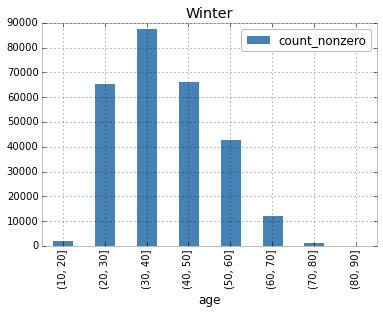

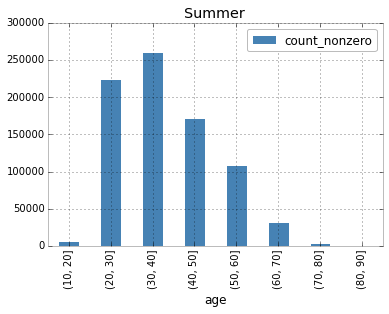

In [12]:
bins = np.arange(10, 99, 10)
df_W.age.groupby(pd.cut(df_W.age, bins)).agg([count_nonzero]).plot(kind='bar', title="Winter")
W_age_dist = df_W.age.groupby(pd.cut(df_W.age, bins)).agg([count_nonzero])
df_S.age.groupby(pd.cut(df_S.age, bins)).agg([count_nonzero]).plot(kind='bar', title="Summer")
S_age_dist = df_S.age.groupby(pd.cut(df_S.age, bins)).agg([count_nonzero])
    

how do they look? what should I expect? setting some expectation is useful as a sanity check!

lets run the scipy KS test

#KS testsfor goodness of fit

http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html

In [13]:
#compare to normal

ksW=scipy.stats.kstest(W_age_dist, 'norm')
ksS=scipy.stats.kstest(S_age_dist, 'norm')
print "winter, normal fit", ksW
print "summer, normal fit", ksS

#compare to poisson 

ksW=scipy.stats.kstest(W_age_dist, 'cauchy')
ksS=scipy.stats.kstest(S_age_dist, 'cauchy')
print "winter, normal fit", ksW
print "summer, normal fit", ksS

winter, normal fit KstestResult(statistic=1.0, pvalue=0.0)
summer, normal fit KstestResult(statistic=1.0, pvalue=0.0)
winter, normal fit KstestResult(statistic=0.99999637418970078, pvalue=0.0)
summer, normal fit KstestResult(statistic=0.9999987788873137, pvalue=0.0)


the scipy KS test works with keywords only for scipy.stats distributions 
that take as a single argument the size of the sample, like norm and cauchy look them up to make sure I am right!
if i want to test against a distribution which takes more arguments like Poisson, which in scipy.stats takes the 
lambda parameter and the size (2 arguments) i can pass the extra arguments in arg, like i do below: 

In [14]:
ksW=scipy.stats.kstest(W_age_dist, 'gamma', args=(35,))
ksS=scipy.stats.kstest(S_age_dist, 'gamma', args=(35,))

print "winter, normal fit", ksW
print "summer, normal fit", ksS

winter, normal fit KstestResult(statistic=1.0, pvalue=0.0)
summer, normal fit KstestResult(statistic=1.0, pvalue=0.0)


or i can create my function separately, then call it: all i need to do is define a function that calls  like i am doing below. the size argument must come first, and the second argument of kstest will no longer be a string, but the function itself (what we would call a "callable")

In [15]:
def mydistribution(size, m0, m1):
    #this is a crazy dumb function, but i am trying to make a point here...
    return (np.empty_like(size)+1) * m0 **2

In [16]:
ksW=scipy.stats.kstest(W_age_dist, mydistribution, args=(35,38))
ksS=scipy.stats.kstest(S_age_dist, mydistribution, args=(35,38))

print "winter, normal fit", ksW
print "summer, normal fit", ksS

winter, normal fit KstestResult(statistic=319324425.0, pvalue=nan)
summer, normal fit KstestResult(statistic=107543975.0, pvalue=nan)


##TODO FOR YOU!

-- repeat with the AD test, and/or any other tests you wish

-- do you see differences in the sample? significant differences?

-- do you dare (and this is indeed optional but could be fun) splitting the samples by up- and down-town?